In [0]:
import torch


In [0]:
# from transformers import *

In [2]:
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609174 sha256=e19567645ba6d5104564edf90ddfe3b25ffd888446967c0762f69ef36f247a7d
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=6623694ccd2eba29da73acc3720ecc29ca1c4ea52af957008ee85b551aed751c
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


In [3]:
!nvidia-smi

Thu Dec 12 00:48:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!pip install transformers

     |████████████████████████████████| 368kB 2.7MB/s 


In [0]:
from __future__ import absolute_import, division, print_function

import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler

# try:
from torch.utils.tensorboard import SummaryWriter
# except:
#     from tensorboardX import SummaryWriter


In [6]:
from tqdm import tqdm, trange

from transformers import (WEIGHTS_NAME, BertConfig,
                                  BertForSequenceClassification, BertTokenizer,
                                  RobertaConfig,
                                  RobertaForSequenceClassification,
                                  RobertaTokenizer,
                                  DistilBertConfig,
                                  DistilBertForSequenceClassification,
                                  DistilBertTokenizer
                                )

from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers import glue_convert_examples_to_features as convert_examples_to_features

In [0]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_auc_score
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tqdm import tqdm, tqdm_notebook
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle

In [0]:
logger = logging.getLogger(__name__)

ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, 
                                                                                RobertaConfig, DistilBertConfig)), ())


In [0]:

MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer)
}


In [0]:
device = torch.device("cuda")

In [0]:
# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = "./"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-uncased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'humor'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
# MAX_SEQ_LENGTH = 30

# TRAIN_BATCH_SIZE = 8
# EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 23
# GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [0]:
output_mode = OUTPUT_MODE

cache_dir = CACHE_DIR

In [0]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [0]:
if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [0]:
MAX_SEQUENCE_LENGTH = 30+2
SEED = 1717
EPOCHS = 1
Data_dir="./"
Input_dir = "./"
WORK_DIR = "./working/"
num_to_load=1000                         #Train size to match time limit
# valid_size= 1000                          #Validation Size
HUMOR_COLUMN = 'score'
num_labels = 2

### Dataframe

In [0]:
import pandas as pd


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# df = pd.read_csv('./short_jokes_even_shorter.csv')
# df = pd.read_csv('/content/gdrive/My Drive/NLP/Project/joke-no-joke2.csv')

df = pd.read_csv('/content/gdrive/My Drive/NLP/Project/shortjokes.csv')

In [0]:
df.head(15)

,original,joke,score
0,""" Gene Cernan , Last Astronaut on the Moon , D...",""" Gene Cernan , Last Dancer on the Moon , Dies...",1.2
1,""" I 'm done "" : Fed up with California , some ...",""" I 'm done "" : Fed up with California , some ...",0.6
2,""" I 'm done "" : Fed up with California , some ...",""" I 'm done "" : Fed up with California , some ...",0.6
3,""" I 'm done "" : Fed up with California , some ...",""" I 'm done "" : Fed up with pancakes , some co...",0.6
4,""" We could be separated "" : Immigrants , famil...",""" We could be separated "" : Immigrants , famil...",0.8
5,""" We could be separated "" : Immigrants , famil...",""" We could be separated "" : Immigrants , famil...",0.8
6,""" We could be separated "" : Immigrants , famil...",""" We could be separated "" : mimes , families r...",1.2
7,#NoMoreNazi is now controversial : New video g...,#NoMoreNazi is now controversial : New video g...,0.6
8,#NoMoreNazi is now controversial : New video g...,#NoMoreNazi is now controversial : New video g...,0.6
9,#NoMoreNazi is now controversial : New video g...,#NoMoreNazi is now controversial : New video g...,0.6


In [0]:
# df = df.drop(labels=['Unnamed: 0'],axis=1)

In [0]:
no_joke_dict = {}

In [0]:
no_jokes = set(list(df['original']))

In [0]:
no_jokes = list(no_jokes)

In [0]:
no_jokes[:5]

[' California to sue Trump administration for repeal of fracking rules',
 'More Than 70 Arrests In North Dakota As Pipeline Detractors Weigh Legal Action ',
 "' I was very angry ' at Trump , says Myeshia Johnson , widow of fallen soldier ",
 'EPA ’s Scott Pruitt asks whether global warming ‘ necessarily is a bad thing ’',
 ' Taylor Swift claims Denver DJ sexually assaulted her back in 2013']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4f7f741d0>]],
      dtype=object)

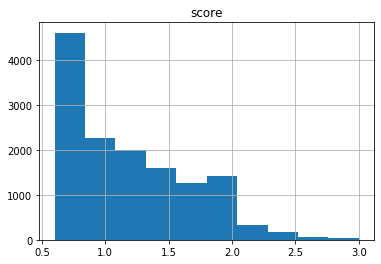

In [0]:
df.hist(column='score')

In [0]:
df.shape

(13764, 3)

In [0]:
len(set(list(df['joke'])))

7088

In [0]:
threshold = 1.0
jokes_threshold = list(set(list(df[df['score'] >= threshold]['joke'])))
no_jokes_threshold = list(set(list(df[df['score'] < threshold]['joke'])))

In [0]:
jokes_threshold = [x.strip('()') for x in jokes_threshold]
no_jokes_threshold = [x.strip('()') for x in no_jokes_threshold]

In [0]:
jokes_threshold = [x.strip('"').strip() for x in jokes_threshold]
no_jokes_threshold = [x.strip('"').strip() for x in no_jokes_threshold]

In [0]:
len(jokes_threshold), len(no_jokes_threshold)

(4725, 2363)

In [0]:
jokes_data = pd.DataFrame(columns=['Joke','Score'])

In [0]:
jokes_data['Joke'] = jokes_threshold + no_jokes_threshold + no_jokes
jokes_data['Score'] = [1]*len(jokes_threshold) + [0]*(len(no_jokes_threshold) + len(no_jokes))

In [0]:
# st = '(asd(fsdv)d)'
# st.strip(')(')

'asd(fsdv)d'

In [0]:
jokes_threshold[0]

'Senate Dems massage Gorsuch , teeing up ‘ nuclear ’ showdown'

In [0]:
jokes_data

,Joke,Score
0,"Senate Dems massage Gorsuch , teeing up ‘ nucl...",1
1,Sanders Leads Pack For Dems 2020 sofa,1
2,Trump 's wacko use of drugs is just another fo...,1
3,A Democrat on Trump 's voter fraud commission ...,1
4,Eric Trump : Those Who support My Dad Are ' No...,1
...,...,...
10966,"Mike Tyson denied entry into Chile , to be sen...",0
10967,Erick Erickson : Trump 's Russia Leak Is ' Far...,0
10968,House to vote Thursday on Obamacare repeal bill,0
10969,Losing : The Failing New York Times Set to Lay...,0


In [0]:
type(jokes_data['Joke'][0])

str

In [0]:
jokes_data['Score'].value_counts()

0    6246
1    4725
Name: Score, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(jokes_data, test_size=0.2)

In [0]:
train_df, val_df = train_test_split(jokes_data, test_size=0.2)

In [0]:
train_df['Score'].value_counts(), val_df['Score'].value_counts()

(0    5008
 1    3768
 Name: Score, dtype: int64, 0    1238
 1     957
 Name: Score, dtype: int64)

### Short-jokes, News

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/NLP/Project/shortjokes.csv')

In [0]:
df['Word_Count'] = df['Joke'].str.split().str.len()
df.hist(column='Word_Count',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc36f6a54e0>]],
      dtype=object)

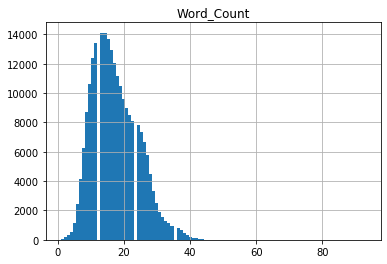

In [0]:
df.hist(column='Word_Count',bins=100)

In [0]:
max(df['Word_Count'])

93

In [0]:
jokes_threshold = df['Joke']

In [0]:
f = open('/content/gdrive/My Drive/NLP/Project/news_non_joke.txt', 'r')
no_jokes_all = f.readlines()
f.close()

In [0]:
no_jokes_threshold = no_jokes_all[:300000]

In [0]:
jokes_threshold = [x.strip() for x in jokes_threshold]
no_jokes_threshold = [x.strip() for x in no_jokes_threshold]

In [0]:
jokes_data = pd.DataFrame(columns=['Joke','Score'])

In [0]:
jokes_data['Joke'] = jokes_threshold + no_jokes_threshold
jokes_data['Score'] = [1]*len(jokes_threshold) + [0]*(len(no_jokes_threshold))

In [0]:
jokes_data.head()

,Joke,Score
0,"[me narrating a documentary about narrators] ""...",1
1,Telling my daughter garlic is good for you. Go...,1
2,I've been going through a really rough period ...,1
3,"If I could have dinner with anyone, dead or al...",1
4,Two guys walk into a bar. The third guy ducks.,1


In [0]:
jokes_data = jokes_data.sample(frac=1)

In [0]:
jokes_data.head()

,Joke,Score
66877,I started a band called 999 megabytes We still...,1
211868,"In the 1970s, a team of racist office supply s...",1
481463,"""Who shot her?"" the dispatcher asked.",0
124992,I thought I had lice. Then I remembered I was ...,1
477876,Making of stone tools may have led to the emer...,0


In [0]:
jokes_data.shape


(531657, 2)

In [0]:
train_df, val_df = train_test_split(jokes_data, test_size=0.3)

In [0]:
train_df.shape

(372159, 2)

### Combined Filtered Dataset

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd

In [0]:
header = ['Id','Score','A','Joke']

In [0]:
train_df = pd.read_csv('/content/gdrive/My Drive/NLP/Project/Humor/data/short_jokes/train.tsv',names=header)

In [0]:
val_df = pd.read_csv('/content/gdrive/My Drive/NLP/Project/Humor/data/short_jokes/dev.tsv',names=header)

In [0]:
train_df.head()

NameError: ignored

In [0]:
train_df.drop(labels=['Id','A'],axis=1,inplace = True)

In [0]:
val_df.drop(labels=['Id','A'],axis=1,inplace = True)

In [0]:
train_df.shape, val_df.shape

((347486, 2), (57914, 2))

In [0]:
train_df.head()

,Score,Joke
0,0,today one kasparov aide reportedly said she wa...
1,1,im scared of trampolines they make me jump.
2,0,white house officials say bush personally noti...
3,0,ms. callaghan’s latest play lascivious somethi...
4,0,the good thing now is we have the farm system ...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f654f949a90>]],
      dtype=object)

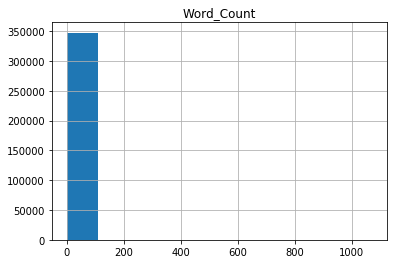

In [0]:
df = train_df.copy()
df['Word_Count'] = df['Joke'].str.split().str.len()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f65722bbba8>]],
      dtype=object)

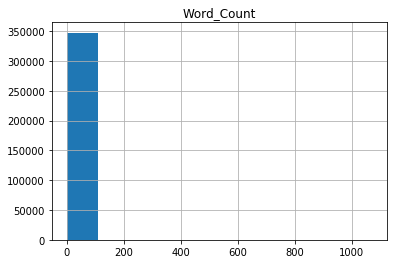

In [0]:
df.hist(column='Word_Count')

In [0]:
df['Word_Count'].describe()

count    347486.000000
mean         19.125936
std          10.712854
min           1.000000
25%          12.000000
50%          18.000000
75%          25.000000
max        1070.000000
Name: Word_Count, dtype: float64

### Bert Continue

In [0]:
MAX_SEQUENCE_LENGTH = 40+2

In [0]:
# Translate model from tensorflow to pytorch
# BERT_MODEL_PATH = '../input/bert-pretrained-models/uncased_l-12_h-768_a-12/uncased_L-12_H-768_A-12/'
# convert_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
#     BERT_MODEL_PATH + 'bert_model.ckpt',
# BERT_MODEL_PATH + 'bert_config.json',
# WORK_DIR + 'pytorch_model.bin')

# shutil.copyfile(BERT_MODEL_PATH + 'bert_config.json', WORK_DIR + 'bert_config.json')

In [0]:
def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_tokens = []
    longer = 0
    for text in tqdm_notebook(example):
        tokens_a = tokenizer.tokenize(text)
        if len(tokens_a)>max_seq_length:
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+[0] * (max_seq_length - len(tokens_a))
        all_tokens.append(one_token)
    print(longer)
    return np.array(all_tokens)

In [22]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR,
                                          do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 431251.88B/s]


In [0]:
# train_df = df.sample(num_to_load+valid_size,random_state=SEED)


In [23]:

print('loaded %d records' % len(train_df))

# Make sure all comment_text values are strings
# train_df['Joke'] = train_df['Joke'].astype(str) 

sequences = convert_lines(train_df["Joke"].fillna("DUMMY_VALUE"),MAX_SEQUENCE_LENGTH,tokenizer)
# train_df=train_df.fillna(0)
# List all identities

y_columns=['Score']


loaded 347486 records



69712


In [0]:
# train_df = train_df.drop(['Joke'],axis=1)
# convert target to 0,1

In [0]:
train_df.head()

,Score,Joke
0,0,today one kasparov aide reportedly said she wa...
1,1,im scared of trampolines they make me jump.
2,0,white house officials say bush personally noti...
3,0,ms. callaghan’s latest play lascivious somethi...
4,0,the good thing now is we have the farm system ...


In [0]:
num_to_load

1000

In [0]:
X = sequences[:]                
y = train_df[y_columns].values[:]


In [0]:
num_to_load = len(sequences)

In [0]:
# test_df=train_df.tail(valid_size).copy()
# train_df=train_df.head(num_to_load)

In [0]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X,dtype=torch.long), torch.tensor(y,dtype=torch.float))

In [0]:
# tqq = torch.utils.data.TensorDataset(torch.tensor(X,dtype=torch.long), torch.tensor(y,dtype=torch.float))

In [0]:
# tqq.tensors[0].shape

In [0]:
# tqq.tensors[1][4] = 0
# tqq.tensors[1][:5]

## Final GPT-2 Evaluations

In [0]:
val_df2 = pd.read_csv('/content/gdrive/My Drive/NLP/Project/final3.csv')

In [29]:
val_df2.head()

,Unnamed: 0,prompt,joke,no_jokes,length
0,0,When did Obama become,When did Obama become president? When he was i...,When did Obama become the first president to h...,4
1,1,What do you call a bee,What do you call a bee that's been hit by a ca...,What do you call a beekeeper?,6
2,2,Who is a man who,Who is a man who can't get a girl pregnant? A ...,Who is a man who is a man who is a man who is ...,5
3,3,I love NLP even though,I love NLP even though I'm not a fan of Nemonos.,I love NLP even though I don't know what it is...,5
4,4,There has never been a time,There has never been a time when I was a kid a...,There has never been a time for a man to be a ...,6


In [0]:
val_df2.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [31]:
val_df2

,prompt,joke,no_jokes,length
0,When did Obama become,When did Obama become president? When he was i...,When did Obama become the first president to h...,4
1,What do you call a bee,What do you call a bee that's been hit by a ca...,What do you call a beekeeper?,6
2,Who is a man who,Who is a man who can't get a girl pregnant? A ...,Who is a man who is a man who is a man who is ...,5
3,I love NLP even though,I love NLP even though I'm not a fan of Nemonos.,I love NLP even though I don't know what it is...,5
4,There has never been a time,There has never been a time when I was a kid a...,There has never been a time for a man to be a ...,6
...,...,...,...,...
96,We removed the most common,We removed the most common word in the English...,We removed the most common forms of the diseas...,5
97,As long as you remember to include these,As long as you remember to include these words...,As long as you remember to include these in yo...,8
98,Brad came to dinner with,Brad came to dinner with a note that said: I'm...,Brad came to dinner with the family.,5
99,Isn't language learning,Isn't language learning like being a prostitut...,Isn't language learning is a good thing. It's ...,3


In [0]:
val_df = pd.DataFrame(columns=['Joke','Score','length'])

In [0]:
val_df['Joke'] = list(val_df2['joke']) + list(val_df2['no_jokes'])

In [0]:
val_df['length'] = list(val_df2['length']) + list(val_df2['length'])

In [0]:
val_df['Score'] = [1]*101 + [0]*101

In [45]:
val_df.head()

,Joke,Score,length
0,When did Obama become president? When he was i...,1,4
1,What do you call a bee that's been hit by a ca...,1,6
2,Who is a man who can't get a girl pregnant? A ...,1,5
3,I love NLP even though I'm not a fan of Nemonos.,1,5
4,There has never been a time when I was a kid a...,1,6


### Training

In [0]:
output_model_file = "bert_pytorch.bin"

lr=2e-5
batch_size = 128
accumulation_steps=8
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True




In [0]:
num_labels

2

In [0]:
# model = BertForSequenceClassification.from_pretrained("../working",cache_dir=None,num_labels=len(y_columns))
model = BertForSequenceClassification.from_pretrained(BERT_MODEL,
                                                      cache_dir=CACHE_DIR, num_labels=num_labels)
model.zero_grad()
model = model.to(device)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

100%|██████████| 440473133/440473133 [00:39<00:00, 11052414.15B/s]


In [0]:
batch_size

128

In [0]:
!nvidia-smi

Sun Dec  8 23:24:50 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |   1271MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
train = train_dataset

num_train_optimization_steps = int(EPOCHS*len(train)/batch_size/accumulation_steps)
warmup_proportion = 0.05
num_warmup_steps = int(warmup_proportion*num_train_optimization_steps)

optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_train_optimization_steps)  # PyTorch scheduler



In [0]:
num_train_optimization_steps, num_warmup_steps

(339, 16)

In [0]:
# model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)
model=model.train()

In [0]:
# inp = torch.randn(3, requires_grad=True)
# target = torch.empty(3).random_(2)
# print (inp,target)
# loss = F.binary_cross_entropy_with_logits(inp, target)
# print (loss)

In [0]:
!nvidia-smi

Sun Dec  8 23:25:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |   1271MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
torch.cuda.empty_cache()

In [0]:
import gc
gc.collect()

525

In [0]:
!nvidia-smi

Sun Dec  8 22:18:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    26W /  75W |   4209MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# m = nn.Softmax(dim=1)
# input = torch.randn(2, 1)
# output = m(input)
# print (output[:])

tensor([[1.],
        [1.]])


In [0]:
output[:,0]

tensor([1., 1.])

In [0]:
EPOCHS = 1

In [0]:
tq = tqdm_notebook(range(EPOCHS))
for epoch in tq:
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    avg_loss = 0.
    avg_accuracy = 0.
    lossf=None
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    optimizer.zero_grad()   
    for i,(x_batch, y_batch) in tk0:
#        optimizer.zero_grad()
        y_batch_int = torch.tensor(y_batch,dtype=torch.long)
        loss, y_pred = model(x_batch.to(device), attention_mask=(x_batch>0).to(device), labels=y_batch_int.to(device))
        # print ()        
        # y_pred = y_pred[0]

        y_soft = F.softmax(y_pred,dim=1)
        # print (y_soft)
        # loss =  F.binary_cross_entropy(y_soft[:,1],y_batch.to(device))
        # loss =  F.binary_cross_entropy_with_logits(y_pred,y_batch.to(device))
        # with amp.scale_loss(loss, optimizer) as scaled_loss:
        
        loss.backward()
        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            # print (i, loss)
            # break
            scheduler.step()
            optimizer.step()                            # Now we can do an optimizer step
            optimizer.zero_grad()
        if lossf:
            lossf = 0.98*lossf+0.02*loss.item()
        else:
            lossf = loss.item()
        tk0.set_postfix(loss = lossf)
        avg_loss += loss.item() /len(train_loader)
        avg_accuracy += torch.mean(((y_soft[:,1]>0.5) == (y_batch[:,0]>0.5).to(device)).to(torch.float) ).item()/len(train_loader)
        
    tq.set_postfix(avg_loss=avg_loss,avg_accuracy=avg_accuracy)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [0]:
!cp ./bert_pytorch.bin /content/gdrive/My\ Drive/NLP/Project/bert_pytorch_e_1.bin

In [0]:
!nvidia-smi


Mon Dec  9 00:10:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   8485MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
y_pred

tensor([[ 0.8680, -0.0398],
        [-0.1450,  0.5821],
        [ 0.3536,  0.6081],
        [-0.0043,  0.5767],
        [ 0.8290, -0.0396],
        [ 0.6233, -0.0959],
        [ 0.5274,  0.0322],
        [ 0.6975,  0.1912]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
torch.save(model.state_dict(), output_model_file)

In [0]:
! zip bert_100k.zip ./bert_pytorch.bin

  adding: bert_pytorch.bin (deflated 7%)


In [0]:
!ls -lhtr

total 811M
drwxr-xr-x 1 root root 4.0K Nov 21 16:30 sample_data
-rw-r--r-- 1 root root  15M Nov 29 04:03 short_jokes_even_shorter.csv
drwxr-xr-x 3 root root 4.0K Nov 29 04:05 reports
drwxr-xr-x 3 root root 4.0K Nov 29 04:05 outputs
drwxr-xr-x 2 root root 4.0K Nov 29 04:32 cache
-rw-r--r-- 1 root root 414M Nov 29 07:23 bert_pytorch.bin
-rw-r--r-- 1 root root 384M Nov 29 07:27 bert_100k.zip


### Validation

In [0]:
!cp /content/gdrive/My\ Drive/NLP/Project/bert_pytorch_e_1.bin ./

In [0]:
output_model_file = './bert_pytorch_e_1.bin'

In [0]:
y_columns =  'Score'

In [47]:
val_sequences = convert_lines(val_df["Joke"].fillna("DUMMY_VALUE"),MAX_SEQUENCE_LENGTH,tokenizer)
X_val = val_sequences



29


In [0]:
y_columns=['Score']
y_val = val_df[y_columns].values[:]

In [0]:
lines = [
         "When did Aditi - go to college? At the end of the day.",
"When did Adi - get her period? When she was told she was going to a mosh pit",
"When did Aditya - become a boxer? When she kicked the can.",
"When did Raghav - os become a boxer? When he was a boxer.",
"When did Emil - io Furilli die? When he was pulled over by a cop.",
"Why did Aditya cross the road? - To get to the other bride.",
"When is - a door not a door? When it's ajar.",
"Who does a chair belong - to? A chair-a-knot.",
"India is my country and all indians are my brothers and sisters"
]


lines = [
         "Who killed the cat that lived next door to the fish market? The catfish market.",
         "Obama flew to Mexico and asked for a Juan.",
         "Obama flew to Mexico to meet Obama and said he wanted to make a small loan of $20 million So Obama flew back to Mexico and said he wanted to make a small loan of $20 million.",
         "Even though I love NLP I'm not sure I'll ever get the taste of a burnt pizza.",
         "I love NLP class It's the only class I can do."
         ""
]
array([0.99951148, 0.4669534 , 0.25318044, 0.9593876 , 0.98591173])

In [0]:
# val_sequences = convert_lines(lines,MAX_SEQUENCE_LENGTH,tokenizer)
# X_val = val_sequences
# # y_val = [0]


0


In [0]:
model1 = model

In [51]:
# The following 2 lines are not needed but show how to download the model for prediction
model = BertForSequenceClassification.from_pretrained(BERT_MODEL,
                                                      cache_dir=CACHE_DIR, num_labels=num_labels)
# model = BertForSequenceClassification(BERT_MODEL, num_labels=len(y_columns))
model.load_state_dict(torch.load(output_model_file ))
model.to(device)

#Sine model already in memory

for param in model.parameters():
    param.requires_grad=False
model.eval()


<All keys matched successfully>

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
valid_preds = np.zeros((len(X_val)))
valid = torch.utils.data.TensorDataset(torch.tensor(X_val,dtype=torch.long))
valid_loader = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=False)

In [53]:
valid_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:

tk0 = tqdm_notebook(valid_loader)
for i,(x_batch,)  in enumerate(tk0):
    pred = model(x_batch.to(device), attention_mask=(x_batch>0).to(device), labels=None)
    pred = pred[0]
    y_soft = F.softmax(pred,dim=1)
    valid_preds[i*32:(i+1)*32]=y_soft[:,1].detach().cpu().squeeze().numpy()

In [55]:
valid_preds

array([9.99326587e-01, 9.99514222e-01, 9.99355257e-01, 6.68179214e-01,
       5.24505861e-02, 2.98492044e-01, 9.99507308e-01, 9.98250544e-01,
       9.93988156e-01, 9.82501566e-01, 9.93656695e-01, 5.05609155e-01,
       9.99471605e-01, 9.99470770e-01, 5.13690233e-01, 9.93915021e-01,
       9.99024510e-01, 9.35709357e-01, 9.99202907e-01, 9.99472797e-01,
       6.09456599e-01, 9.99417186e-01, 9.99500275e-01, 9.99453723e-01,
       9.99533415e-01, 9.99463260e-01, 9.99363959e-01, 9.58557963e-01,
       7.66638696e-01, 2.98492044e-01, 9.99504805e-01, 9.98250544e-01,
       9.98423338e-01, 9.98451710e-01, 9.96537805e-01, 9.98663425e-01,
       9.79648888e-01, 9.93437946e-01, 9.94434178e-01, 9.99129474e-01,
       8.21609437e-01, 4.21059072e-01, 3.13006878e-01, 7.72898376e-01,
       2.04310551e-01, 3.30719203e-01, 8.09607089e-01, 9.99466240e-01,
       1.66107733e-02, 6.61492109e-01, 6.17649697e-04, 9.93142605e-01,
       1.67495742e-01, 5.14412940e-01, 9.96852577e-01, 9.97852087e-01,
      

In [0]:
pred,y_soft

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [0]:
all_preds = np.zeros((len(valid_preds),2))
all_preds[:,0] = 1.0 - valid_preds
all_preds[:,1] = valid_preds

In [0]:
from sklearn.metrics import log_loss,accuracy_score

In [0]:
def get_accu(y_val,y_pred):
  # accuracy = np.mean(y_val == y_pred)
  accuracy = accuracy_score(y_val,y_pred)
  return accuracy
def get_log_loss(all_preds, y_val):
  return log_loss(y_val,all_preds)


In [0]:
ans = (valid_preds > 0.5).astype('int')

In [106]:
ans

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1])

In [107]:
get_accu(ans,y_val), get_log_loss(all_preds, y_val)
#(0.9816624650343613, 0.04888365158775222) ,, (0.983199226439203, 0.045723491122633055)

(0.6831683168316832, 1.3059373879023382)

In [77]:
print(f1_score(y_val, ans, average="macro"))
print(precision_score(y_val, ans, average="macro"))
print(recall_score(y_val, ans, average="macro")) 

0.6781468317195735
0.6783751962323391
0.6782178217821782


In [0]:
get_accu(y_val,ans), get_log_loss(all_preds, y_val)
(0.5258604926292413, 0.6071352625484814)

(0.5258604926292413, 0.6071352625484814)

In [0]:
len(valid_preds[0])

TypeError: ignored

In [109]:
val_df.head()

,Joke,Score,length
0,When did Obama become president? When he was i...,1,4
1,What do you call a bee that's been hit by a ca...,1,6
2,Who is a man who can't get a girl pregnant? A ...,1,5
3,I love NLP even though I'm not a fan of Nemonos.,1,5
4,There has never been a time when I was a kid a...,1,6


In [0]:
val_df['Prediction'] = valid_preds

In [111]:
val_df

,Joke,Score,length,Prediction
0,When did Obama become president? When he was i...,1,4,0.999327
1,What do you call a bee that's been hit by a ca...,1,6,0.999514
2,Who is a man who can't get a girl pregnant? A ...,1,5,0.999355
3,I love NLP even though I'm not a fan of Nemonos.,1,5,0.668179
4,There has never been a time when I was a kid a...,1,6,0.052451
...,...,...,...,...
197,We removed the most common forms of the diseas...,0,5,0.001345
198,As long as you remember to include these in yo...,0,8,0.007013
199,Brad came to dinner with the family.,0,5,0.004048
200,Isn't language learning is a good thing. It's ...,0,3,0.999156


In [0]:
all_preds

array([[0.62822467, 0.37177533],
       [0.51839241, 0.48160759],
       [0.40274501, 0.59725499],
       ...,
       [0.74858615, 0.25141385],
       [0.33969468, 0.66030532],
       [0.43152595, 0.56847405]])

In [0]:
results = pd.DataFrame(columns=['Length','Accuracy'])

In [0]:
accu = [0]*11
cnt = [0]*11
threshold = 0.5
def func(row):
  # print (row)
  val = int(row['Prediction'] >= threshold)
  ind = row['length']
  cnt[ind] +=1
  if val == row['Score']:
    accu[ind] +=1

  return 0



In [121]:
val_df.apply(func,axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
197    0
198    0
199    0
200    0
201    0
Length: 202, dtype: int64

In [124]:
accu, cnt

([0, 0, 0, 31, 24, 31, 21, 11, 13, 4, 3],
 [0, 0, 0, 38, 34, 52, 34, 16, 16, 8, 4])

In [0]:
for i in range(11):
  if cnt[i]!=0:
    accu[i]/=cnt[i]

In [0]:
results['Length'] = range(3,11)
results['Accuracy'] = accu[3:]

In [131]:
results

,Length,Accuracy
0,3,0.815789
1,4,0.705882
2,5,0.596154
3,6,0.617647
4,7,0.687500
5,8,0.812500
6,9,0.500000
7,10,0.750000


In [132]:
import seaborn as sns

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [0]:
val_df.to_csv('./predictions.csv',index=False)

In [0]:
!cp ./predictions.csv /content/gdrive/My\ Drive/NLP/Project/

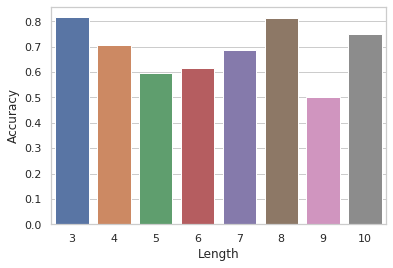

In [141]:
sns.set(style="whitegrid")

ax = sns.barplot(x="Length", y="Accuracy", data=results)

In [143]:
ax.savefig("./length-vs-accuracy.png")

AttributeError: ignored

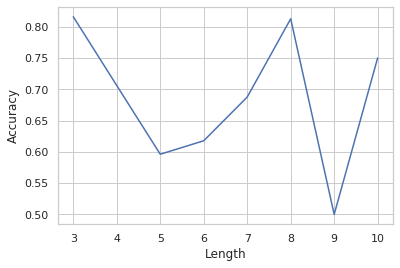

In [139]:
ax = sns.lineplot(x="Length", y="Accuracy", data=results)

ValueError: ignored

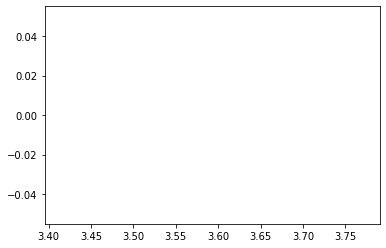

In [133]:
sns.distplot(results,)

In [0]:
# !pip install pytorch-pretrained-bert

In [0]:
%

In [0]:
%%bash

# export BERT_BASE_DIR=./uncased_L-24_H-1024_A-16
# export CUDA_VISIBLE_DEVICES=0
# python3 run_classifier.py \
# --task_name=cola \
# --do_train \
# --do_eval \
# --data_dir=./data \
# --max_seq_length=128 \
# --train_batch_size=256 \
# --learning_rate=2e-5 \
# --num_train_epochs=1.0 \
# --do_lower_case \
# --gradient_accumulation_steps 24 \
# --bert_model=bert-base-uncased \
# --output_dir=./final_results \
